In [1]:
import itertools
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import graphviz
%matplotlib inline
def get_scores(model, args, X, y, testX, testy):
    # args : {name: [val1, val2,...],...}
    out = []
    for param in itertools.product(args.values()):
        a = {k:v for k,v in zip(args.keys(), param)}
        reg = model(**a)
        reg = model.fit_transform(X, y)
        a["train"] = reg.score(X, y)
        a["test"] = reg.score(testX, testy)
        out.append(a)
    df = pd.DataFrame(a)
    return df

In [319]:
tmp = pd.read_csv("test.csv", encoding="cp932", header=0)
tmp.genre.str.split("'", expand=True).iloc[:,7].unique()
tmp.sub_genre.str.split("'", expand=True).iloc[:,7].value_counts()

和食             598
居酒屋            383
ダイニングバー・バル     193
創作料理           155
中華              32
焼肉・ホルモン         22
イタリアン・フレンチ      21
韓国料理            13
カラオケ・パーティ        9
洋食               7
アジア・エスニック料理      2
お好み焼き・もんじゃ       2
バー・カクテル          1
カフェ・スイーツ         1
各国料理             1
Name: 7, dtype: int64

In [299]:
# Tree model preproc
df = pd.read_csv("test3.csv", encoding="cp932", header=0)
# X = pd.get_dummies(df.loc[:,"middle_area":"midnight"])
X = df.loc[:,"middle_area":"midnight"]
y = df["score"]
labels = []
bool_cols = ["free_drink", "free_food", "private_room", "horigotatsu", "tatami", "card",
             "charter", "parking", "barrier_free", "show", "karaoke", "band", "tv", "english", "pet", "lunch", "midnight"]
variable_cols = ["genre", "sub_genre", "middle_area", "non_smoking"]
other_cols = {"budget": ['501～1000円', '1001～1500円', '1501～2000円', '2001～3000円', '3001～4000円', '4001～5000円', '5001～7000円', '7001～10000円', '20001～30000円'
]}
for col in bool_cols+variable_cols:
    val, label = pd.factorize(X[col])
    X[col] = val
    labels.append(label)
for col, vals in other_cols.items():
    for ind, item in enumerate(vals):
        X[col][X[col]==item] = ind
X.columns
cols = ['budget', 'capacity', 'free_food', 'private_room', 'horigotatsu', 'tatami', 'card',
       'barrier_free', 'english', 'pet', 'lunch', 'midnight']
# X = X[cols]

C:\anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [297]:
# Tree model execute
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
models = (DecisionTreeRegressor(random_state=0, min_samples_split=250),
         RandomForestRegressor(n_estimators=100, random_state=0, min_samples_split=100))
out = []
for reg in models:
    reg.fit(X_train, y_train)
    print(reg)
    print("  train score: {}".format(np.array(cross_val_score(reg, X_train, y_train, cv=5).mean())))
#     print("  test score: {}".format(cross_val_score(reg, X_test, y_test, cv=5)))
    out.append(pd.DataFrame({"true": y_test, "predict": reg.predict(X_test)}))
    if isinstance(reg, DecisionTreeRegressor):
        export_graphviz(reg, out_file="tree.dot", class_names=["malignant", "benign"])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=250,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')
  train score: 0.13265266926337574
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=100, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
  train score: 0.17292924918000888


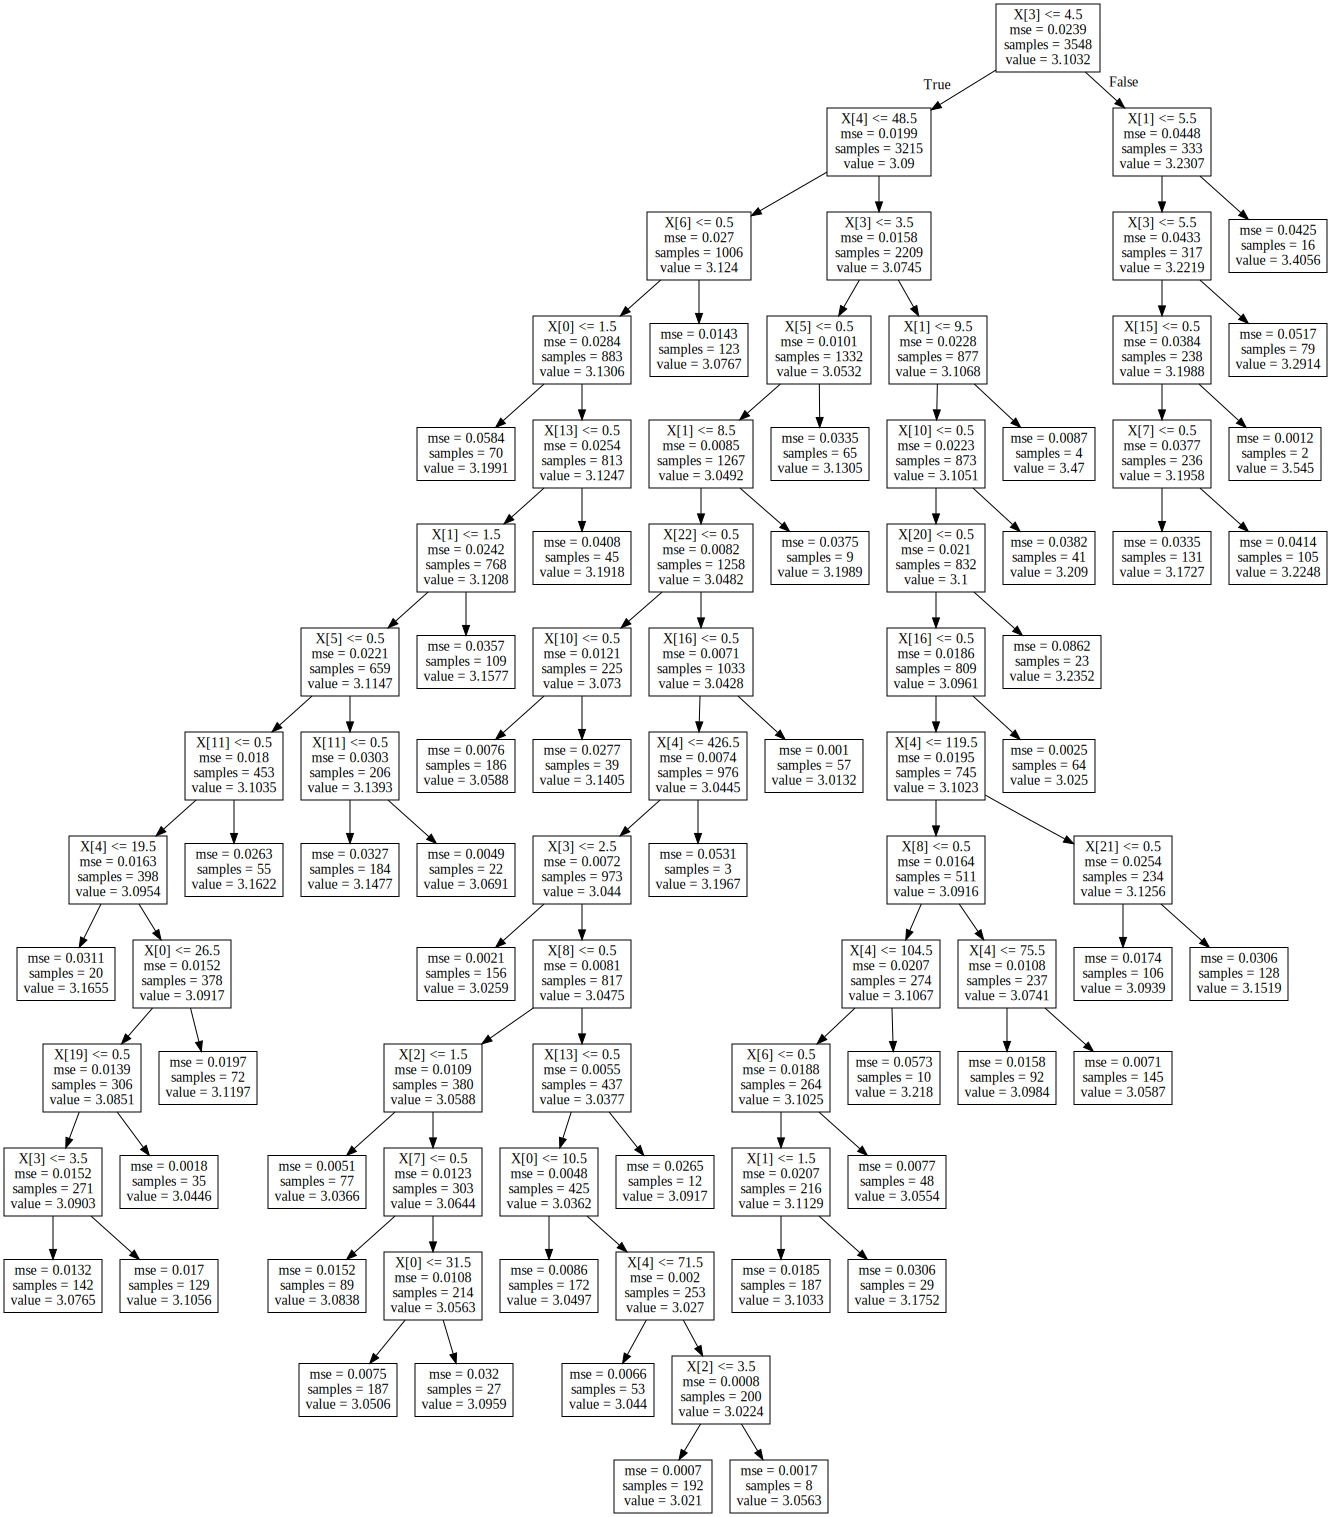

In [272]:
with open("tree.dot",) as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [138]:
# PCA
scaler = StandardScaler()
scaler.fit(X)
X_s = scaler.transform(X)
pca = PCA(n_components=2)
pca.fit(X_s)
X_pca = pca.transform(X_s)

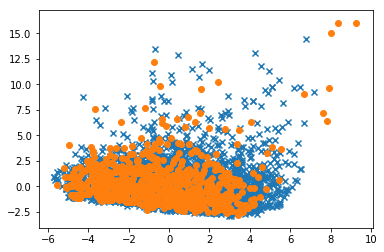

In [126]:
# PCA plot
markers = np.zeros(df.shape[0], dtype=object)
high = (df.score>3.2)
low = (df.score<=3.2)
markers[high] = "o"
markers[low] = "x"
plt.scatter(X_pca[:,0][low], X_pca[:,1][low], marker="x")
plt.scatter(X_pca[:,0][high], X_pca[:,1][high], marker="o")

In [298]:
# Linear models
# input_X = PolynomialFeatures(degree=2).fit_transform(X)
input_X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(input_X,y, random_state=42)
models = (LinearRegression(), Ridge(alpha=0.1), Lasso(alpha=0.001),
          MLPRegressor(hidden_layer_sizes=(100,100), alpha=1e-3))
out = []

for reg in models:
    reg.fit(X_train, y_train)
    print(reg)
    print("  train score: {}".format(cross_val_score(reg, X_train, y_train, cv=5)))    
    print("  test score: {}".format(reg.score(X_test, y_test)))
    out.append(pd.DataFrame({"true": y_test, "predict": reg.predict(X_test)}))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
  train score: [ 0.13736033  0.10792288  0.12982119  0.12941927  0.14864585]
  test score: 0.1757863405731752
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
  train score: [ 0.13753349  0.10810533  0.12983124  0.12951381  0.14879404]
  test score: 0.1757872163058104
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
  train score: [ 0.14618522  0.1137809   0.12101907  0.13840988  0.13746304]
  test score: 0.16368397172164073
MLPRegressor(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nes

In [226]:
params = {"n_estimators":[10], "random_state":[0], "min_samples_split":[50]}
get_scores(RandomForestRegressor, params, X_train, y_train, X_test, y_test)

AttributeError: 'DataFrame' object has no attribute 'fit'

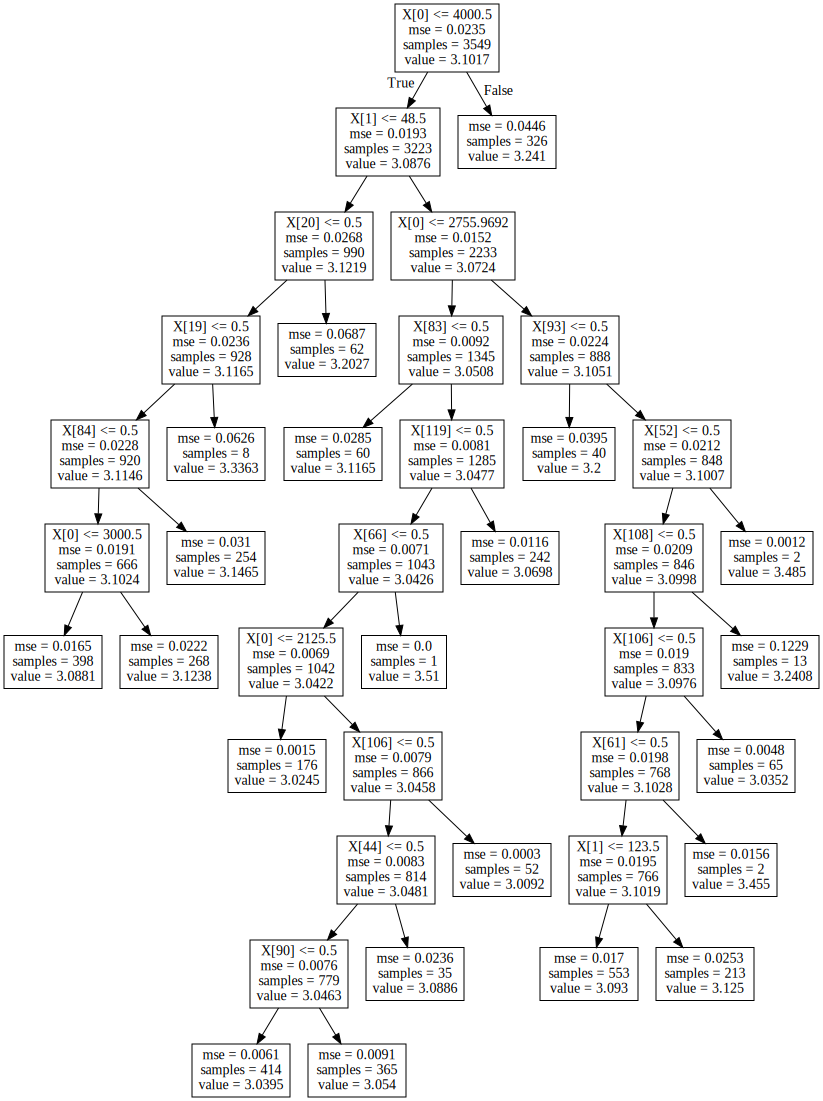

In [153]:
y_test

2307    3.19
354     3.02
1397    3.29
3366    3.03
2036    3.05
227     3.02
1102    3.02
1187    3.02
3674    3.07
3226    3.00
2753    3.00
1918    3.01
296     3.00
2727    3.00
199     3.07
964     3.00
3859    3.09
1563    3.03
33      3.04
4438    3.07
4076    3.07
1101    3.04
4296    3.06
4135    3.08
2823    3.03
2630    3.08
2920    3.13
1270    3.05
1253    3.02
373     3.05
        ... 
1268    3.10
620     3.04
1162    3.04
3158    3.00
328     3.05
3895    3.16
897     3.02
2215    3.08
1123    3.30
4692    3.08
4399    3.00
1533    3.08
1183    3.00
3999    3.02
1221    3.19
3239    3.11
2217    3.52
2979    3.38
2186    3.07
3344    3.01
2819    3.55
809     3.03
978     3.03
2787    3.00
2452    3.32
1420    3.00
2277    3.08
2555    3.06
2596    3.09
1264    3.02
Name: score, Length: 1184, dtype: float64